<a href="https://colab.research.google.com/github/bhaviii17/Arth/blob/main/Arth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
with open("/content/drive/MyDrive/Colab Datasets/noisy_data+1.txt", "r", encoding="utf-8") as file:
    raw_data = file.read()


In [3]:
import re
import json

# Extract all person records
person_records = re.findall(r'name,[^{}]+?dpd,\d+', raw_data)

# Extract all loan records
loan_records = re.findall(r'\{.*?\}', raw_data)


In [4]:
people = []

for record in person_records:
    try:
        parts = record.split(',')
        person = {
            "name": parts[1],
            "gender": parts[3],
            "address": parts[5].strip('"'),
            "pan": parts[7],
            "dob": parts[9],
            "dpd": int(parts[-1])
        }
        people.append(person)
    except Exception as e:
        print("Error parsing person:", record)


In [5]:
loans = []

for record in loan_records:
    try:
        loan = json.loads(record)
        loans.append(loan)
    except json.JSONDecodeError:
        print("Invalid loan JSON:", record)


Streaming output truncated to the last 5000 lines.
Invalid loan JSON: {'}
Invalid loan JSON: {:-	]}
Invalid loan JSON: {.__}
Invalid loan JSON: {zx.}
Invalid loan JSON: {&"~$+``}
Invalid loan JSON: {,~#$&}
Invalid loan JSON: {*#`(}
Invalid loan JSON: {-{[ _|-"\ }
Invalid loan JSON: {F>N0Z}
Invalid loan JSON: {/	}
Invalid loan JSON: {!,]<>?}
Invalid loan JSON: {#QE}
Invalid loan JSON: {./_\-&}
Invalid loan JSON: {#:(@[}
Invalid loan JSON: {(2T7b}
Invalid loan JSON: {({"*(~@? }
Invalid loan JSON: {?`mpV2}
Invalid loan JSON: {:  }
Invalid loan JSON: { bDVt}
Invalid loan JSON: {=Xr(2ZO/I	*G* Ux%	zhd}
Invalid loan JSON: {$	|<;{ {}
Invalid loan JSON: {(}
Invalid loan JSON: {Oyu)}
Invalid loan JSON: {@|!/}
Invalid loan JSON: {({}
Invalid loan JSON: {z:G[r1+&+~O:j}
Invalid loan JSON: {`&}
Invalid loan JSON: {5\}
Invalid loan JSON: {{[	}
Invalid loan JSON: {(}
Invalid loan JSON: {'##}
Invalid loan JSON: {~}
Invalid loan JSON: {#}
Invalid loan JSON: {"[}
Invalid loan JSON: {jLu?wy2Q~Ly

In [6]:
import pandas as pd

df_people = pd.DataFrame(people)
df_loans = pd.DataFrame(loans)

# Save to files
df_people.to_csv("cleaned_people.csv", index=False)
df_loans.to_csv("cleaned_loans.csv", index=False)


In [8]:
import pandas as pd

# Load both datasets
people_df = pd.read_csv("cleaned_people.csv")
loans_df = pd.read_csv("cleaned_loans.csv")


In [9]:
!pip install -q pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())


  Preparing metadata (setup.py) ... done


In [12]:
people_df["user_id"] = range(1, len(people_df)+1)
loans_df["user_id"] = range(1, len(loans_df)+1)


In [13]:
query = """
SELECT p.name, p.gender, p.address, p.pan, p.dob, p.dpd AS user_dpd,
       l.loan_id, l.amount, l.tenure, l.status, l.start_date, l.dpd AS loan_dpd
FROM people_df p
JOIN loans_df l
ON p.user_id = l.user_id
"""
joined_df = pysqldf(query)
joined_df.head()


,name,gender,address,pan,dob,user_dpd,loan_id,amount,tenure,status,start_date,loan_dpd
0,WceglPvX,M,"""SEBdv City""",SORYY9548O,07-01-2004,29,LN88613,49261.0,6.0,default,2022-06-06,87.0
1,JHfqkIiR,M,"""mCVTs City""",STVIB7040K,09-06-1972,13,LN41507,179148.0,36.0,closed,2024-09-26,40.0
2,XITlFISo,F,"""KJJrH City""",WMKII1787Y,08-02-1972,41,LN91801,370496.0,12.0,default,2024-10-16,17.0
3,clYjjoBt,F,"""OLgiX City""",SMDRM1175N,23-08-2000,21,LN32796,172410.0,12.0,default,2021-09-05,34.0
4,GKaIAMIf,M,"""fsioz City""",UZJYL6658I,26-02-1984,65,LN33975,392574.0,24.0,closed,2021-10-03,89.0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
people = pd.read_csv("cleaned_people.csv")
loans = pd.read_csv("cleaned_loans.csv")

# Create artificial join key
people['user_id'] = range(1, len(people) + 1)
loans['user_id'] = range(1, len(loans) + 1)

# Merge datasets
df = pd.merge(people, loans, on="user_id", suffixes=('_user', '_loan'))


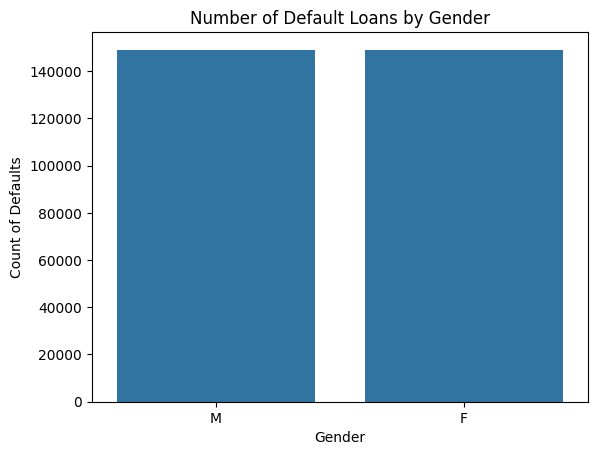

In [15]:
# Filter only default loans
default_df = df[df["status"] == "default"]

# Count of default loans by gender
gender_defaults = default_df["gender"].value_counts()

# Plot
sns.barplot(x=gender_defaults.index, y=gender_defaults.values)
plt.title("Number of Default Loans by Gender")
plt.xlabel("Gender")
plt.ylabel("Count of Defaults")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


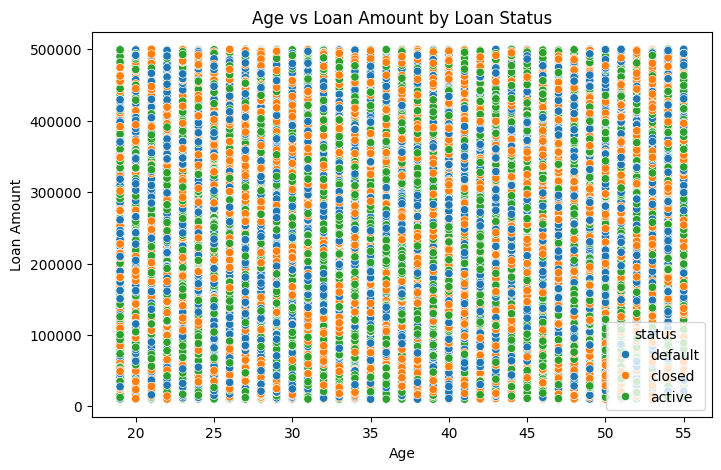

In [16]:
from datetime import datetime

# Convert DOB to age
df["dob"] = pd.to_datetime(df["dob"], format="%d-%m-%Y")
df["age"] = (pd.Timestamp.now() - df["dob"]).dt.days // 365

# Scatter plot of Age vs Loan Amount
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="age", y="amount", hue="status")
plt.title("Age vs Loan Amount by Loan Status")
plt.xlabel("Age")
plt.ylabel("Loan Amount")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


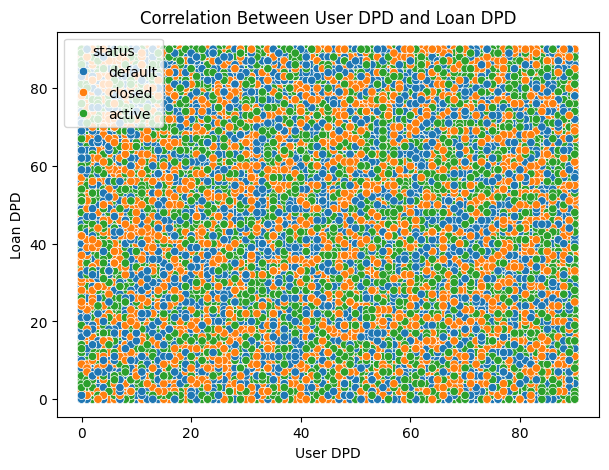

In [17]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="dpd_user", y="dpd_loan", hue="status")
plt.title("Correlation Between User DPD and Loan DPD")
plt.xlabel("User DPD")
plt.ylabel("Loan DPD")
plt.show()


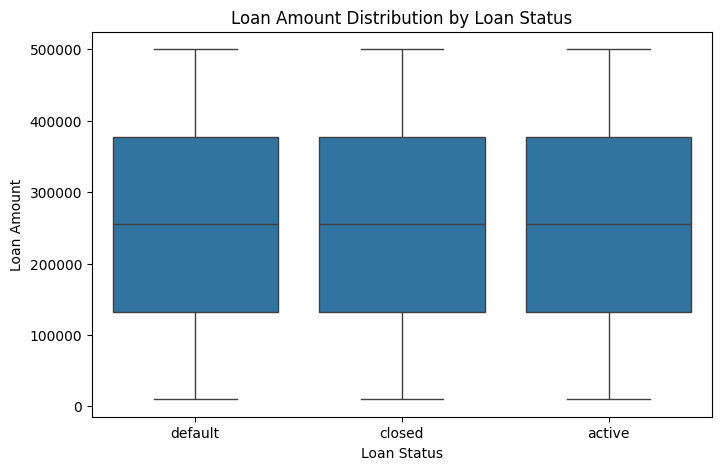

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="status", y="amount")
plt.title("Loan Amount Distribution by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount")
plt.show()


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:

df.to_csv("joined_dataset.csv", index=False)


df = pd.read_csv("joined_dataset.csv")

# Convert DOB to Age
df["dob"] = pd.to_datetime(df["dob"], format='mixed', dayfirst=True, errors='coerce')
print(df[df["dob"].isna()])
df["age"] = (pd.Timestamp.now() - df["dob"]).dt.days // 365


# Convert start_date
df["start_date"] = pd.to_datetime(df["start_date"])

# Encode categorical target
df["status_binary"] = df["status"].apply(lambda x: 1 if x == "default" else 0)


Empty DataFrame
Columns: [name, gender, address, pan, dob, dpd_user, user_id, loan_id, amount, tenure, status, start_date, dpd_loan, age]
Index: []


In [23]:
# Feature selection
features = ["dpd_user", "dpd_loan", "amount", "tenure", "age"]
X = df[features]
y = df["status_binary"]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.impute import SimpleImputer

# Create an imputer that fills NaNs with the median (for numeric data)
imputer = SimpleImputer(strategy='median')

# Fit and transform X_train and X_test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [27]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80    121468
           1       0.00      0.00      0.00     59389

    accuracy                           0.67    180857
   macro avg       0.34      0.50      0.40    180857
weighted avg       0.45      0.67      0.54    180857



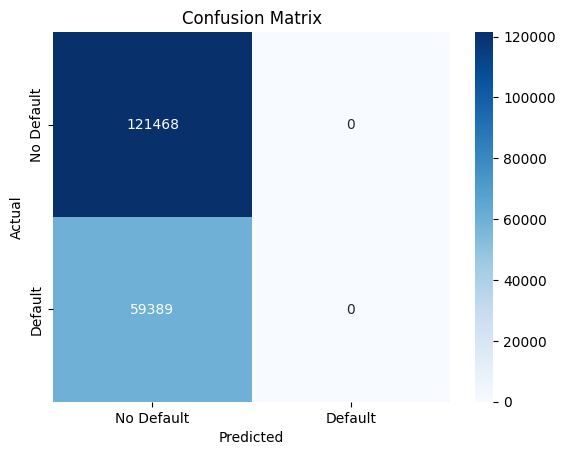

In [28]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


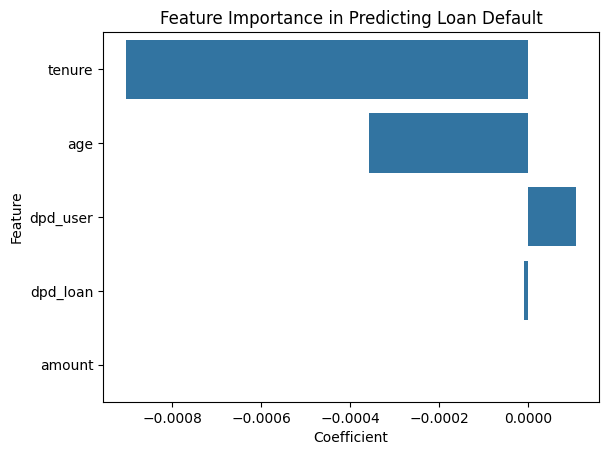

In [29]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

sns.barplot(x="Coefficient", y="Feature", data=coefficients)
plt.title("Feature Importance in Predicting Loan Default")
plt.show()
